In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import time
import gc

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="white")

from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import f1_score, mean_squared_error, mean_absolute_error
from sklearn.decomposition import PCA
import xgboost as xgb

In [2]:
IDIR = '../../data/'
print('loading prior')
priors = pd.read_csv(IDIR + 'order_products__prior.csv', dtype={
            'order_id': np.int32,
            'product_id': np.uint16,
            'add_to_cart_order': np.int16,
            'reordered': np.int8})

print('loading train')
train = pd.read_csv(IDIR + 'order_products__train.csv', dtype={
            'order_id': np.int32,
            'product_id': np.uint16,
            'add_to_cart_order': np.int16,
            'reordered': np.int8})

print('loading orders')
orders = pd.read_csv(IDIR + 'orders.csv', dtype={
        'order_id': np.int32,
        'user_id': np.int32,
        'eval_set': 'category',
        'order_number': np.int16,
        'order_dow': np.int8,
        'order_hour_of_day': np.int8,
        'days_since_prior_order': np.float32})


print('priors {}: {}'.format(priors.shape, ', '.join(priors.columns)))
print('orders {}: {}'.format(orders.shape, ', '.join(orders.columns)))

priors = priors.merge(orders, how='left', on='order_id', suffixes='_r')
train = train.merge(orders, how='left', on='order_id', suffixes='_r')
priors.head(5)

loading prior
loading train
loading orders
priors (32434489, 4): order_id, product_id, add_to_cart_order, reordered
orders (3421083, 7): order_id, user_id, eval_set, order_number, order_dow, order_hour_of_day, days_since_prior_order


,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2,33120,1,1,202279,prior,3,5,9,8.0
1,2,28985,2,1,202279,prior,3,5,9,8.0
2,2,9327,3,0,202279,prior,3,5,9,8.0
3,2,45918,4,1,202279,prior,3,5,9,8.0
4,2,30035,5,0,202279,prior,3,5,9,8.0


In [15]:
usersXorders = pd.DataFrame()
usersXorders['order_size'] = priors.groupby('order_id')['product_id'].size()
usersXorders.reset_index(inplace=True)
usersXorders = usersXorders.merge(orders, how='left', on='order_id', suffixes=('', '_r'))
usersXorders = usersXorders.drop('eval_set', axis=1)
print(usersXorders.head(5), '\n')

usersXorders_val = pd.DataFrame()
usersXorders_val['order_size'] = train.groupby('order_id')['product_id'].size()
usersXorders_val.reset_index(inplace=True)
usersXorders_val = usersXorders_val.merge(orders, how='left', on='order_id', suffixes=('', '_r'))
usersXorders_val = usersXorders_val.drop('eval_set', axis=1)
usersXorders_val.head(5)

   order_id  order_size  user_id  order_number  order_dow  order_hour_of_day  \
0         2           9   202279             3          5                  9   
1         3           8   205970            16          5                 17   
2         4          13   178520            36          1                  9   
3         5          26   156122            42          6                 16   
4         6           3    22352             4          1                 12   

   days_since_prior_order  
0                     8.0  
1                    12.0  
2                     7.0  
3                     9.0  
4                    30.0   



,order_id,order_size,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,1,8,112108,4,4,10,9.0
1,36,8,79431,23,6,18,30.0
2,38,9,42756,6,6,16,24.0
3,96,7,17227,7,6,20,30.0
4,98,49,56463,41,3,8,14.0


In [16]:
users = pd.DataFrame()
users['average_days_between_orders'] = orders.groupby('user_id')['days_since_prior_order'].mean().astype(np.float32)
users['nb_orders'] = orders.groupby('user_id').size().astype(np.int16) # orders data gives user_id, order_id
users['total_items'] = priors.groupby('user_id').size().astype(np.int16) # priors data gives order_id, product_id
users['all_products'] = priors.groupby('user_id')['product_id'].apply(set)
users['total_distinct_items'] = (users['all_products'].map(len)).astype(np.int16)
users['average_basket'] = (users['total_items'] / users['nb_orders']).astype(np.float32)
users['user_id'] = users.index
users.to_csv('users.csv', index=False)
print(users.shape)
users.head()

(206209, 7)


,average_days_between_orders,nb_orders,total_items,all_products,total_distinct_items,average_basket,user_id
user_id,,,,,,,
1,19.000000,11,59,"{17122, 196, 26405, 46149, 14084, 13032, 26088...",18,5.363636,1
2,16.285715,15,195,"{45066, 2573, 18961, 23, 32792, 1559, 22559, 1...",102,13.000000,2
3,12.000000,13,88,"{17668, 44683, 48523, 21903, 14992, 21137, 324...",33,6.769231,3
4,17.000000,6,18,"{21573, 42329, 17769, 35469, 37646, 1200, 1905...",17,3.000000,4
5,11.500000,5,37,"{11777, 40706, 28289, 48775, 20754, 6808, 1398...",23,7.400000,5


In [17]:
usersXorders = usersXorders.merge(users, on='user_id', how='left', suffixes=('', '_r'))
usersXorders = usersXorders.drop(['all_products'], axis=1)

usersXorders_val = usersXorders_val.merge(users, on='user_id', how='left', suffixes=('', '_r'))
usersXorders_val = usersXorders_val.drop(['all_products'], axis=1)

print(usersXorders.shape, usersXorders_val.shape)
usersXorders_val.head()

(3214874, 12) (131209, 12)


,order_id,order_size,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,average_days_between_orders,nb_orders,total_items,total_distinct_items,average_basket
0,1,8,112108,4,4,10,9.0,10.333333,4,21,12,5.250000
1,36,8,79431,23,6,18,30.0,15.681818,23,187,101,8.130435
2,38,9,42756,6,6,16,24.0,22.400000,6,39,31,6.500000
3,96,7,17227,7,6,20,30.0,21.000000,7,43,33,6.142857
4,98,49,56463,41,3,8,14.0,9.050000,41,1234,207,30.097561


# Randomly pick a user to inspect the behavior
## Data Exploration

In [62]:
n_transactions = orders.groupby('user_id').size().astype(np.int16)
n_transactions[n_transactions == 100]
# user_ = usersXorders[usersXorders['user_id'] == 204485]

(99, 7)

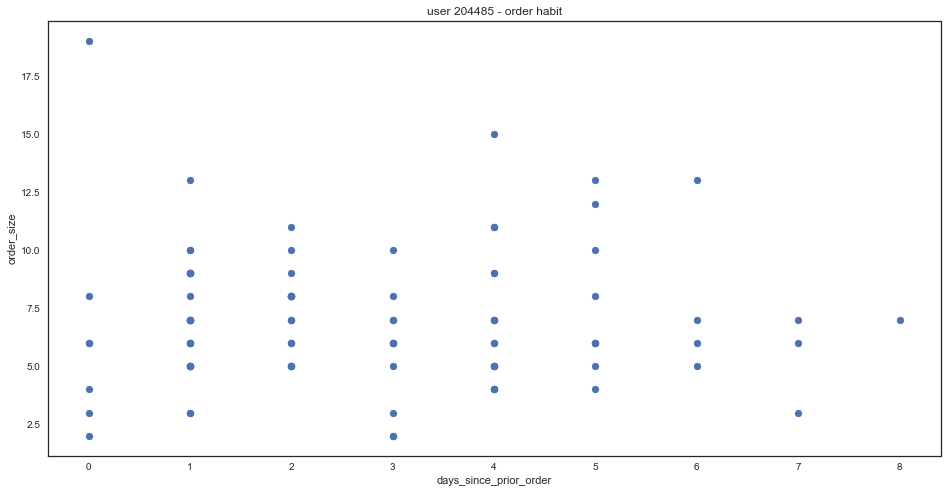

In [70]:
_ = plt.figure(figsize=(16, 8))
_ = plt.scatter(user_.loc[:, 'days_since_prior_order'], user_.loc[:, 'order_size'])
_ = plt.xlabel('days_since_prior_order')
_ = plt.ylabel('order_size')
_ = plt.title('user 204485 - order habit')

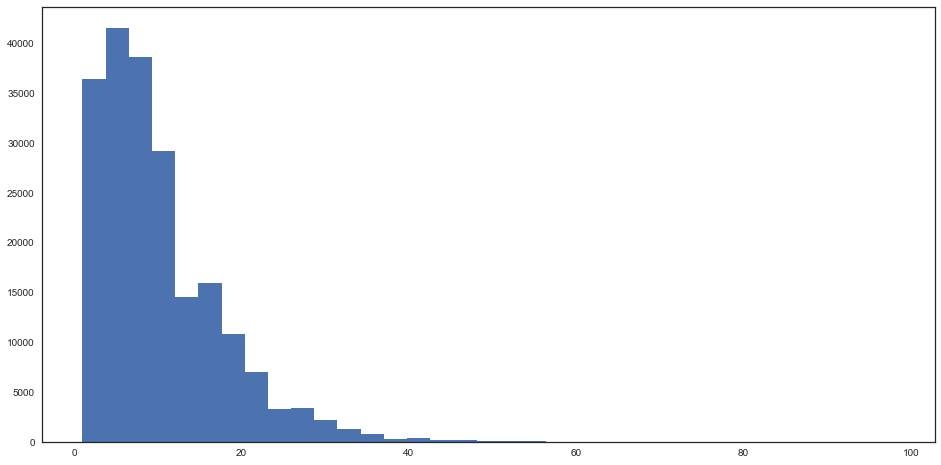

In [92]:
# np.sum(usersXorders.isnull())
_ = plt.figure(figsize=(16,8))
_ = plt.hist(usersXorders[usersXorders['days_since_prior_order'].isnull()]['order_size'], bins=35)

# Prepare DataFrame for training and Save

In [18]:
# Prior data as train set
label = usersXorders['order_size']
order_id = usersXorders['order_id']
user_id = usersXorders['user_id']


# Save features and labels:
usersXorders.to_csv('usersXorders_features.csv', index=False)
label.to_csv('usersXorders_labels.csv', index=False)
print(usersXorders.shape, label.shape)
print(usersXorders.head(), '\n')
usersXorders = usersXorders.drop(['order_size', 'order_id', 'user_id'], axis=1)


# Train data as validation set
label_val = usersXorders_val['order_size']
order_id_val = usersXorders_val['order_id']
user_id_val = usersXorders_val['user_id']


# Save features and labels:
usersXorders_val.to_csv('usersXorders_val_features.csv', index=False)
label_val.to_csv('usersXorders_val_labels.csv', index=False)
print(usersXorders_val.shape, label_val.shape)
print(usersXorders_val.head())
usersXorders_val = usersXorders_val.drop(['order_size', 'order_id', 'user_id'], axis=1)

(3214874, 12) (3214874,)
   order_id  order_size  user_id  order_number  order_dow  order_hour_of_day  \
0         2           9   202279             3          5                  9   
1         3           8   205970            16          5                 17   
2         4          13   178520            36          1                  9   
3         5          26   156122            42          6                 16   
4         6           3    22352             4          1                 12   

   days_since_prior_order  average_days_between_orders  nb_orders  \
0                     8.0                    22.625000          9   
1                    12.0                     9.240000         26   
2                     7.0                     6.500000         57   
3                     9.0                     6.673077         53   
4                    30.0                    24.500000          9   

   total_items  total_distinct_items  average_basket  
0           90          

# Directly Load Data and Model

In [7]:
usersXorders = pd.read_csv('./usersXorders_features.csv')
label = pd.read_csv('./usersXorders_labels.csv')

# Load Model
bst = xgb.Booster()
bst.load_model('./xgb_order_size')
usersXorders.shape, label.shape

((3214874, 4), (3214874,))

In [19]:
params = {
    'objective': 'reg:linear', 
    'eval_metric': 'rmse', 
    'eta': 0.2, 
    'subsample' : 0.76,
    'colsample_bytree' : 0.95
}

    
print('Prepare DMatrix...')
d_train = xgb.DMatrix(usersXorders, label = label)
d_valid = xgb.DMatrix(usersXorders_val, label = label_val)
watchlist = [(d_train, 'train'), (d_valid, 'val')]

print('Training...')
bst = xgb.train(params = params, \
                dtrain = d_train, \
                num_boost_round = 200, \
                evals = watchlist, \
                verbose_eval = 10, \
                early_stopping_rounds = 50)

Prepare DMatrix...
Training...
[0]	train-rmse:10.2011	val-rmse:10.9084
Multiple eval metrics have been passed: 'val-rmse' will be used for early stopping.

Will train until val-rmse hasn't improved in 50 rounds.
[10]	train-rmse:5.04184	val-rmse:5.92225
[20]	train-rmse:4.92081	val-rmse:5.77352
[30]	train-rmse:4.90309	val-rmse:5.76147
[40]	train-rmse:4.89374	val-rmse:5.75781
[50]	train-rmse:4.88776	val-rmse:5.75803
[60]	train-rmse:4.88311	val-rmse:5.75835
[70]	train-rmse:4.87933	val-rmse:5.75968
[80]	train-rmse:4.87543	val-rmse:5.75873
Stopping. Best iteration:
[35]	train-rmse:4.89762	val-rmse:5.75697



In [20]:
# Save XGB model.
bst.save_model('xgb_order_size')

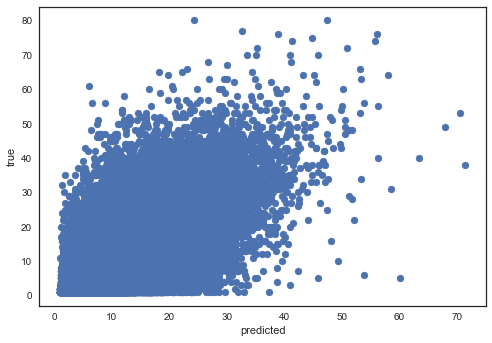

In [21]:
pred_val = bst.predict(xgb.DMatrix(usersXorders_val))
_ = plt.scatter(pred_val, label_val.as_matrix())
_ = plt.xlabel('predicted')
_ = plt.ylabel('true')

In [22]:
print('MSE', mean_squared_error(label_val.as_matrix(), pred_val))
print('RMSE', mean_squared_error(label_val.as_matrix(), pred_val)**0.5)
print('MAE', mean_absolute_error(label_val.as_matrix(), pred_val))

# 61.1062765204
# 7.81705037213
# 5.90722489387

MSE 33.1604790318
RMSE 5.75851361306
MAE 4.05523850035


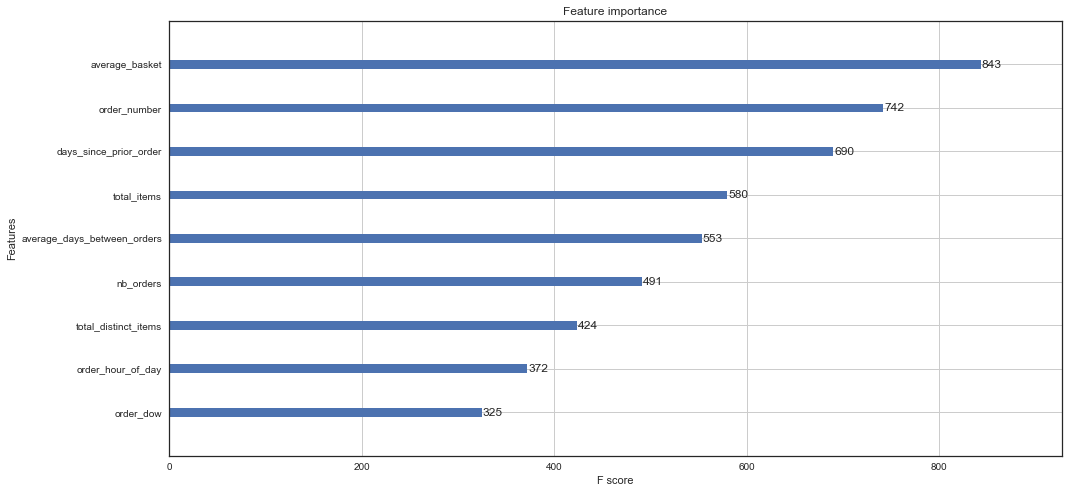

In [23]:
plt.rcParams["figure.figsize"] = (16, 8)
_ = xgb.plot_importance(bst)

In [24]:
usersXorders.head()

,order_number,order_dow,order_hour_of_day,days_since_prior_order,average_days_between_orders,nb_orders,total_items,total_distinct_items,average_basket
0,3,5,9,8.0,22.625000,9,90,47,10.000000
1,16,5,17,12.0,9.240000,26,323,133,12.423077
2,36,1,9,7.0,6.500000,57,923,107,16.192982
3,42,6,16,9.0,6.673077,53,967,154,18.245283
4,4,1,12,30.0,24.500000,9,91,83,10.111111


In [30]:
print(label_val[order_id_val == 96])
print(user_id_val[order_id_val == 96])
usersXorders_val[order_id_val == 96]

3    7
Name: order_size, dtype: int64
3    17227
Name: user_id, dtype: int32


,order_number,order_dow,order_hour_of_day,days_since_prior_order,average_days_between_orders,nb_orders,total_items,total_distinct_items,average_basket
3,7,6,20,30.0,21.0,7,43,33,6.142857
